## MMD-VAE, to create a more disentangled latent space

One way of making a more disentangled latent space besides beta-vae is to modify the KL term in the ELBO and replace it with a maximum mean discrepancy (MMD) term that always prefers maximising the mutual information in the latent code, resulting in a more disentangled latent space, as shown by [Zhao et al. 17](https://arxiv.org/pdf/1706.02262.pdf). This can be seen from the following image below comparing the latent space of a VAE trained on MNIST using the KL term vs the MMD term, which is more structured than the KL term.

In [1]:
%%capture
# @title Setup and installation { display-mode: "form" }

!sudo apt-get install subversion
!svn checkout https://github.com/probml/pyprobml/trunk/vae .

try:
    import umap
except ModuleNotFoundError:
    %pip install -qq umap-learn
    import umap
try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from functools import partial
from torch import nn
import torch.nn.functional as F

try:
    from einops import rearrange
except ModuleNotFoundError:
    %pip install -qq einops
    from einops import rearrange
from sklearn.manifold import TSNE

try:
    from torchvision.datasets import MNIST
except ModuleNotFoundError:
    %pip install -qq torchvision
    from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

try:
    from pytorch_lightning import Trainer
except ModuleNotFoundError:
    %pip install -qq pytorch_lightning
    from pytorch_lightning import Trainer
try:
    from models.guassian_vae import VAE
except ModuleNotFoundError:
    %pip install -qq models
    from models.guassian_vae import VAE
from models.vanilla_vae import kl_divergence
from models.mmd_vae import MMD

try:
    from experiment import VAEModule, VAE2stageModule
except ModuleNotFoundError:
    %pip install -qq experiment
    from experiment import VAEModule, VAE2stageModule

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_embedder(encoder, X_data, y_data=None, use_embedder="TSNE"):
    X_data_2D = encoder(X_data)
    if X_data_2D.shape[-1] == 2:
        return X_data_2D
    if use_embedder == "UMAP":
        umap_fn = umap.UMAP()
        X_data_2D = umap_fn.fit_transform(X_data_2D, y_data)
    elif use_embedder == "TSNE":
        tsne = TSNE()
        X_data_2D = tsne.fit_transform(X_data_2D)
    return X_data_2D


def plot_scatter_plot(batch, vae, use_embedder="TSNE", min_distance=0.01):
    """
    Plots scatter plot of embeddings
    """

    def encoder(img):
        return vae.det_encode(img).cpu().detach().numpy()

    model_name = vae.model_name
    X_data, y_data = batch
    X_data = X_data.to(device)
    np.random.seed(42)
    X_data_2D = get_embedder(encoder, X_data, y_data, use_embedder)
    X_data_2D = (X_data_2D - X_data_2D.min()) / (X_data_2D.max() - X_data_2D.min())

    # adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
    fig = plt.figure(figsize=(10, 8))
    cmap = plt.cm.tab10
    plt.scatter(X_data_2D[:, 0], X_data_2D[:, 1], c=y_data, s=10, cmap=cmap)
    image_positions = np.array([[1.0, 1.0]])
    plt.title(f"Latent space of {model_name}")
    for index, position in enumerate(X_data_2D):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > 0.04:  # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            imagebox = matplotlib.offsetbox.AnnotationBbox(
                matplotlib.offsetbox.OffsetImage(X_data[index].reshape(28, 28).cpu(), cmap="binary"),
                position,
                bboxprops={"edgecolor": tuple(cmap([y_data[index]])[0]), "lw": 2},
            )
            plt.gca().add_artist(imagebox)
    plt.axis("off")
    return fig

In [ ]:
# @title Code to quickly train MNIST VAE { display-mode: "form" }


def kl_loss(config, x, x_hat, z, mu, logvar):
    recons_loss = F.binary_cross_entropy(x_hat, x, reduction="mean")

    kld_loss = kl_divergence(mu, logvar)

    loss = recons_loss + config["kl_coeff"] * kld_loss
    return loss


def mmd_loss(config, x, x_hat, z, mu, logvar):
    recons_loss = F.binary_cross_entropy(x_hat, x, reduction="mean")

    mmd = MMD(torch.randn_like(z), z)

    loss = recons_loss + config["beta"] * mmd
    return loss


class Encoder(nn.Module):
    def __init__(self, latent_dim: int = 256):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(nn.Linear(28 * 28, 512), nn.ReLU())
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_var = nn.Linear(512, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim: int = 256):
        super(Decoder, self).__init__()

        # Build Decoder
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 512), nn.ReLU(), nn.Linear(512, 28 * 28), nn.Sigmoid())

    def forward(self, z):
        result = self.decoder(z)
        return result


lr = 0.001
latent_dim = 2
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)

encoder2 = Encoder(latent_dim)
decoder2 = Decoder(latent_dim)

mnist_full = MNIST(
    ".",
    download=True,
    train=True,
    transform=transforms.Compose([transforms.ToTensor(), lambda x: rearrange(x, "c h w -> (c h w)")]),
)
dm = DataLoader(mnist_full, batch_size=500, shuffle=True)

kl_loss = partial(kl_loss, {"kl_coeff": 1})
mmd_loss = partial(mmd_loss, {"beta": 1})
vanilla_vae = VAE("vanilla_vae", kl_loss, encoder, decoder)
vanilla_vae = VAEModule(vanilla_vae, lr, latent_dim)

mmd_vae = VAE("mmd_vae", mmd_loss, encoder2, decoder2)
mmd_vae = VAEModule(mmd_vae, lr, latent_dim)

trainer1 = Trainer(gpus=1, weights_summary="full", max_epochs=10)
trainer1.fit(vanilla_vae, dm)

trainer2 = Trainer(gpus=1, weights_summary="full", max_epochs=10)
trainer2.fit(mmd_vae, dm)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")
LOCAL_RANK:

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type       | Params
--------------------------------------------------------
0  | model                   | VAE        | 807 K 
1  | model.encoder           | Encoder    | 403 K 
2  | model.encoder.encoder   | Sequential | 401 K 
3  | model.encoder.encoder.0 | Linear     | 401 K 
4  | model.encoder.encoder.1 | ReLU       | 0     
5  | model.encoder.fc_mu     | Linear     | 1.0 K 
6  | model.encoder.fc_var    | Linear     | 1.0 K 
7  | model.decoder           | Decoder    | 403 K 
8  | model.decoder.decoder   | Sequential | 403 K 

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

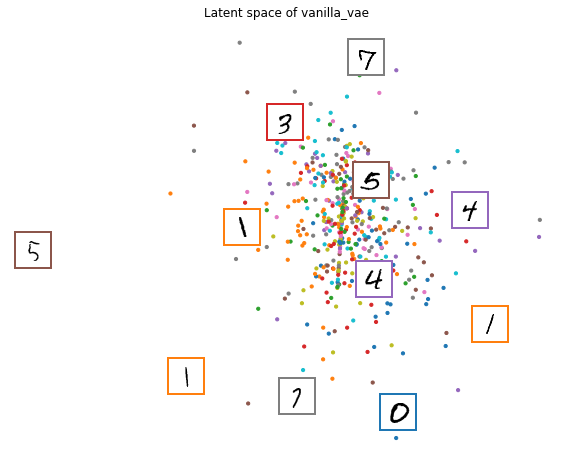

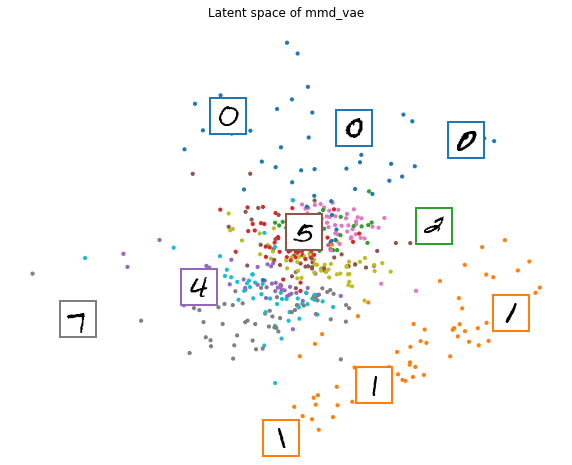

In [ ]:
batch_mnist = next(iter(dm))
fig = plot_scatter_plot(batch_mnist, vanilla_vae)
fig2 = plot_scatter_plot(batch_mnist, mmd_vae)